# Analise de Dados de Dengue - Taxas Normalizadas (por 10.000 casos)

## Objetivo
Este notebook apresenta a mesma analise do `analise_dengue.ipynb`, porem com **valores normalizados por 10.000 casos**.

A normalizacao permite comparacoes mais justas entre grupos de tamanhos diferentes, eliminando o vies do volume absoluto.

### Por que 10.000?
- Para taxas internas do dataset (obitos/casos, hospitalizacoes/casos), usamos 10.000 como base
- Facilita a interpretacao: "X casos a cada 10.000 notificacoes"
- Padrao comum em epidemiologia para proporcoes dentro de uma populacao de estudo

### Metricas Normalizadas
1. **Taxa de obitos por 10.000 casos notificados** (por faixa etaria, regiao, etc.)
2. **Taxa de hospitalizacao por 10.000 casos**
3. **Proporcao de sintomas por 10.000 casos** (para comparacao entre grupos)
4. **Distribuicao proporcional** (percentuais)

## 1. Importar Bibliotecas e Configuracoes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os

# Configuracoes
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Constante de normalizacao
TAXA_BASE = 10000  # Taxa por 10.000 casos

# Criar pasta para graficos normalizados
pasta_graficos = 'GRAFICOS/NORMALIZADOS'
if not os.path.exists(pasta_graficos):
    os.makedirs(pasta_graficos)
    print(f"Pasta '{pasta_graficos}/' criada!")

print(f"Configuracoes carregadas!")
print(f"Base de normalizacao: {TAXA_BASE:,} casos")

Pasta 'GRAFICOS/NORMALIZADOS/' criada!
Configuracoes carregadas!
Base de normalizacao: 10,000 casos


## 2. Carregar Dados (2022-2025)

In [2]:
# Carregar todos os arquivos CSV
pasta_dados = Path('BASE DE DADOS')
arquivos_csv = sorted(pasta_dados.glob('DENGBR*.csv'))

print(f"Arquivos encontrados: {len(arquivos_csv)}")
for arq in arquivos_csv:
    print(f"  - {arq.name}")

# Carregar e concatenar
lista_dfs = []
for arq in arquivos_csv:
    print(f"\nCarregando {arq.name}...", end=" ")
    df_temp = pd.read_csv(arq, encoding='latin-1', low_memory=False)
    ano = '20' + arq.stem.replace('DENGBR', '')
    df_temp['ANO_BASE'] = int(ano)
    lista_dfs.append(df_temp)
    print(f"{len(df_temp):,} registros")

df = pd.concat(lista_dfs, ignore_index=True)

print(f"\n{'='*60}")
print(f"Dataset consolidado: {df.shape[0]:,} registros x {df.shape[1]} colunas")
print(f"Anos: {sorted(df['ANO_BASE'].unique())}")

Arquivos encontrados: 4
  - DENGBR22.csv
  - DENGBR23.csv
  - DENGBR24.csv
  - DENGBR25.csv

Carregando DENGBR22.csv... 1,393,877 registros

Carregando DENGBR23.csv... 1,508,653 registros

Carregando DENGBR24.csv... 6,427,053 registros

Carregando DENGBR25.csv... 1,668,787 registros

Dataset consolidado: 10,998,370 registros x 122 colunas
Anos: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


## 3. Tratamento de Dados e Criacao de Variaveis

In [3]:
# Funcao para decodificar idade SINAN
def decodificar_idade_sinan(valor):
    try:
        valor = int(valor)
        if valor < 1000:
            return valor
        tipo = valor // 1000
        quantidade = valor % 1000
        if tipo == 4:
            return quantidade
        elif tipo == 3:
            return quantidade / 12
        elif tipo == 2:
            return quantidade / 365
        elif tipo == 1:
            return quantidade / (365 * 24)
        else:
            return np.nan
    except:
        return np.nan

# Decodificar idade
df['IDADE_ANOS'] = df['NU_IDADE_N'].apply(decodificar_idade_sinan)

# Criar faixas etarias
def classificar_faixa_etaria(idade):
    if pd.isna(idade) or idade < 0:
        return 'Nao informado'
    elif idade <= 15:
        return 'Criancas (0-15)'
    elif idade <= 23:
        return 'Jovens (15-23)'
    elif idade <= 60:
        return 'Adultos (23-60)'
    else:
        return 'Idosos (60+)'

df['FAIXA_ETARIA'] = df['IDADE_ANOS'].apply(classificar_faixa_etaria)
ordem_faixas = ['Criancas (0-15)', 'Jovens (15-23)', 'Adultos (23-60)', 'Idosos (60+)', 'Nao informado']
df['FAIXA_ETARIA'] = pd.Categorical(df['FAIXA_ETARIA'], categories=ordem_faixas, ordered=True)

# Criar coluna de regiao
uf_para_regiao = {
    11: 'Norte', 12: 'Norte', 13: 'Norte', 14: 'Norte', 15: 'Norte', 16: 'Norte', 17: 'Norte',
    21: 'Nordeste', 22: 'Nordeste', 23: 'Nordeste', 24: 'Nordeste', 25: 'Nordeste', 
    26: 'Nordeste', 27: 'Nordeste', 28: 'Nordeste', 29: 'Nordeste',
    31: 'Sudeste', 32: 'Sudeste', 33: 'Sudeste', 35: 'Sudeste',
    41: 'Sul', 42: 'Sul', 43: 'Sul',
    50: 'Centro-Oeste', 51: 'Centro-Oeste', 52: 'Centro-Oeste', 53: 'Centro-Oeste'
}

coluna_uf = 'SG_UF_NOT' if 'SG_UF_NOT' in df.columns else 'SG_UF'
uf_valores = pd.to_numeric(df[coluna_uf].astype(str), errors='coerce')
df['REGIAO'] = uf_valores.map(uf_para_regiao)

print("Variaveis criadas com sucesso!")
print(f"\nDistribuicao por Faixa Etaria:")
print(df['FAIXA_ETARIA'].value_counts())

Variaveis criadas com sucesso!

Distribuicao por Faixa Etaria:
FAIXA_ETARIA
Adultos (23-60)    6100176
Criancas (0-15)    1898084
Jovens (15-23)     1556891
Idosos (60+)       1443219
Nao informado            0
Name: count, dtype: int64


## 4. Analise Normalizada: Distribuicao por Faixa Etaria

In [4]:
# Filtrar registros validos
df_valido = df[df['FAIXA_ETARIA'] != 'Nao informado'].copy()
total_validos = len(df_valido)

print(f"Total de registros validos: {total_validos:,}")
print(f"\n{'='*70}")
print(f"DISTRIBUICAO POR FAIXA ETARIA - VALORES ABSOLUTOS E NORMALIZADOS")
print(f"{'='*70}")
print(f"\n{'Faixa Etaria':<20} {'Casos':>12} {'Percentual':>12} {'Por {0:,}'.format(TAXA_BASE):>15}")
print("-" * 60)

faixas_validas = ['Criancas (0-15)', 'Jovens (15-23)', 'Adultos (23-60)', 'Idosos (60+)']
contagem = df_valido['FAIXA_ETARIA'].value_counts()

dados_normalizados = []
for faixa in faixas_validas:
    casos = contagem.get(faixa, 0)
    percentual = (casos / total_validos) * 100
    taxa_normalizada = (casos / total_validos) * TAXA_BASE
    print(f"{faixa:<20} {casos:>12,} {percentual:>11.2f}% {taxa_normalizada:>14.1f}")
    dados_normalizados.append({
        'Faixa Etaria': faixa,
        'Casos': casos,
        'Percentual': percentual,
        f'Por {TAXA_BASE:,}': taxa_normalizada
    })

print("-" * 60)
print(f"{'TOTAL':<20} {total_validos:>12,} {100:>11.2f}% {TAXA_BASE:>14.1f}")

df_dist_normalizada = pd.DataFrame(dados_normalizados)

Total de registros validos: 10,998,370

DISTRIBUICAO POR FAIXA ETARIA - VALORES ABSOLUTOS E NORMALIZADOS

Faixa Etaria                Casos   Percentual      Por 10,000
------------------------------------------------------------
Criancas (0-15)         1,898,084       17.26%         1725.8
Jovens (15-23)          1,556,891       14.16%         1415.6
Adultos (23-60)         6,100,176       55.46%         5546.4
Idosos (60+)            1,443,219       13.12%         1312.2
------------------------------------------------------------
TOTAL                  10,998,370      100.00%        10000.0


Grafico salvo em: GRAFICOS/NORMALIZADOS/01_distribuicao_normalizada.png


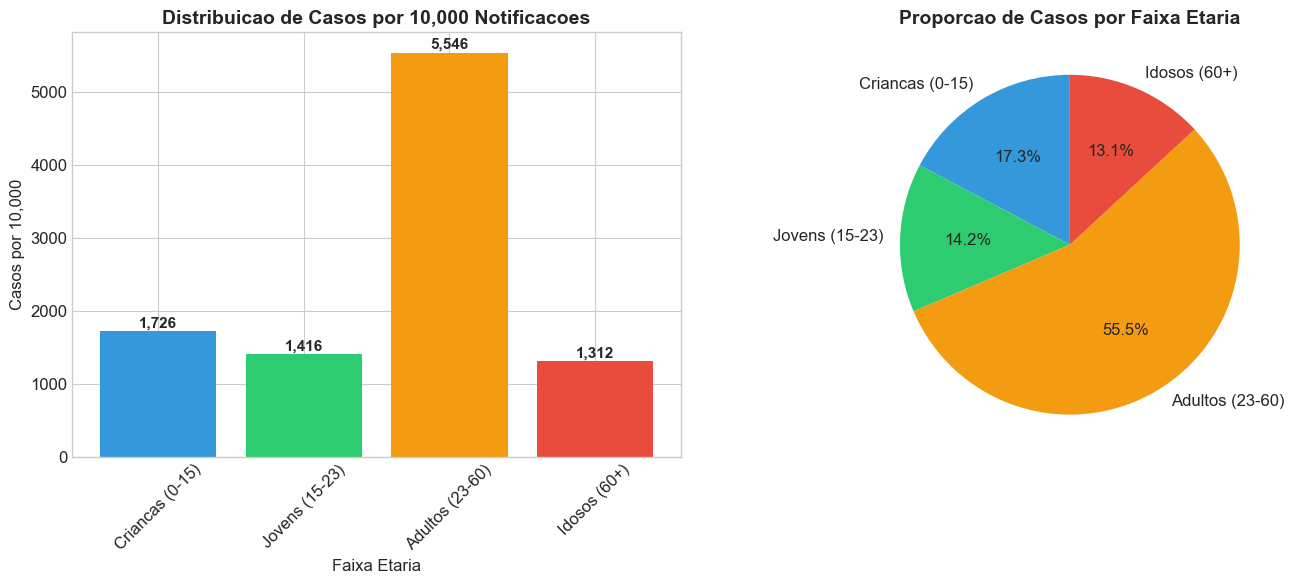

In [5]:
# Visualizacao: Distribuicao Normalizada
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

# Grafico de barras - Proporcao por 10.000
taxa_col = f'Por {TAXA_BASE:,}'
bars = axes[0].bar(df_dist_normalizada['Faixa Etaria'], df_dist_normalizada[taxa_col], color=colors)
axes[0].set_title(f'Distribuicao de Casos por {TAXA_BASE:,} Notificacoes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Faixa Etaria')
axes[0].set_ylabel(f'Casos por {TAXA_BASE:,}')
axes[0].tick_params(axis='x', rotation=45)

for bar, val in zip(bars, df_dist_normalizada[taxa_col]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{val:,.0f}', ha='center', fontsize=11, fontweight='bold')

# Grafico de pizza - Percentual
axes[1].pie(df_dist_normalizada['Percentual'], labels=df_dist_normalizada['Faixa Etaria'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Proporcao de Casos por Faixa Etaria', fontsize=14, fontweight='bold')

plt.tight_layout()
fig.savefig(f'{pasta_graficos}/01_distribuicao_normalizada.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Grafico salvo em: {pasta_graficos}/01_distribuicao_normalizada.png")
plt.show()

## 5. Taxa de Obitos Normalizada por Faixa Etaria

In [6]:
# Identificar obitos (EVOLUCAO = 2 significa obito pelo agravo)
df_valido['OBITO'] = (df_valido['EVOLUCAO'] == 2).astype(int)

print(f"{'='*80}")
print(f"TAXA DE OBITOS POR {TAXA_BASE:,} CASOS NOTIFICADOS - POR FAIXA ETARIA")
print(f"{'='*80}")
print(f"\n{'Faixa Etaria':<20} {'Casos':>12} {'Obitos':>10} {'Taxa/%':>10} {'Por {0:,}'.format(TAXA_BASE):>12}")
print("-" * 70)

dados_obitos = []
for faixa in faixas_validas:
    df_faixa = df_valido[df_valido['FAIXA_ETARIA'] == faixa]
    casos = len(df_faixa)
    obitos = df_faixa['OBITO'].sum()
    taxa_percentual = (obitos / casos * 100) if casos > 0 else 0
    taxa_normalizada = (obitos / casos * TAXA_BASE) if casos > 0 else 0
    
    print(f"{faixa:<20} {casos:>12,} {obitos:>10,} {taxa_percentual:>9.3f}% {taxa_normalizada:>11.1f}")
    dados_obitos.append({
        'Faixa Etaria': faixa,
        'Casos': casos,
        'Obitos': obitos,
        'Taxa (%)': taxa_percentual,
        f'Por {TAXA_BASE:,}': taxa_normalizada
    })

# Total
total_obitos = df_valido['OBITO'].sum()
taxa_geral = (total_obitos / total_validos * 100)
taxa_geral_norm = (total_obitos / total_validos * TAXA_BASE)
print("-" * 70)
print(f"{'TOTAL':<20} {total_validos:>12,} {total_obitos:>10,} {taxa_geral:>9.3f}% {taxa_geral_norm:>11.1f}")

df_obitos_norm = pd.DataFrame(dados_obitos)

# Calcular razao de risco relativo (usando jovens como referencia)
taxa_jovens = df_obitos_norm[df_obitos_norm['Faixa Etaria'] == 'Jovens (15-23)'][f'Por {TAXA_BASE:,}'].values[0]
print(f"\n\nRAZAO DE RISCO RELATIVO (referencia: Jovens):")
print("-" * 50)
for _, row in df_obitos_norm.iterrows():
    razao = row[f'Por {TAXA_BASE:,}'] / taxa_jovens if taxa_jovens > 0 else 0
    print(f"  {row['Faixa Etaria']}: {razao:.1f}x")

TAXA DE OBITOS POR 10,000 CASOS NOTIFICADOS - POR FAIXA ETARIA

Faixa Etaria                Casos     Obitos     Taxa/%   Por 10,000
----------------------------------------------------------------------
Criancas (0-15)         1,898,084        432     0.023%         2.3
Jovens (15-23)          1,556,891        334     0.021%         2.1
Adultos (23-60)         6,100,176      3,224     0.053%         5.3
Idosos (60+)            1,443,219      6,221     0.431%        43.1
----------------------------------------------------------------------
TOTAL                  10,998,370     10,211     0.093%         9.3


RAZAO DE RISCO RELATIVO (referencia: Jovens):
--------------------------------------------------
  Criancas (0-15): 1.1x
  Jovens (15-23): 1.0x
  Adultos (23-60): 2.5x
  Idosos (60+): 20.1x


Grafico salvo em: GRAFICOS/NORMALIZADOS/02_taxa_obitos_normalizada.png


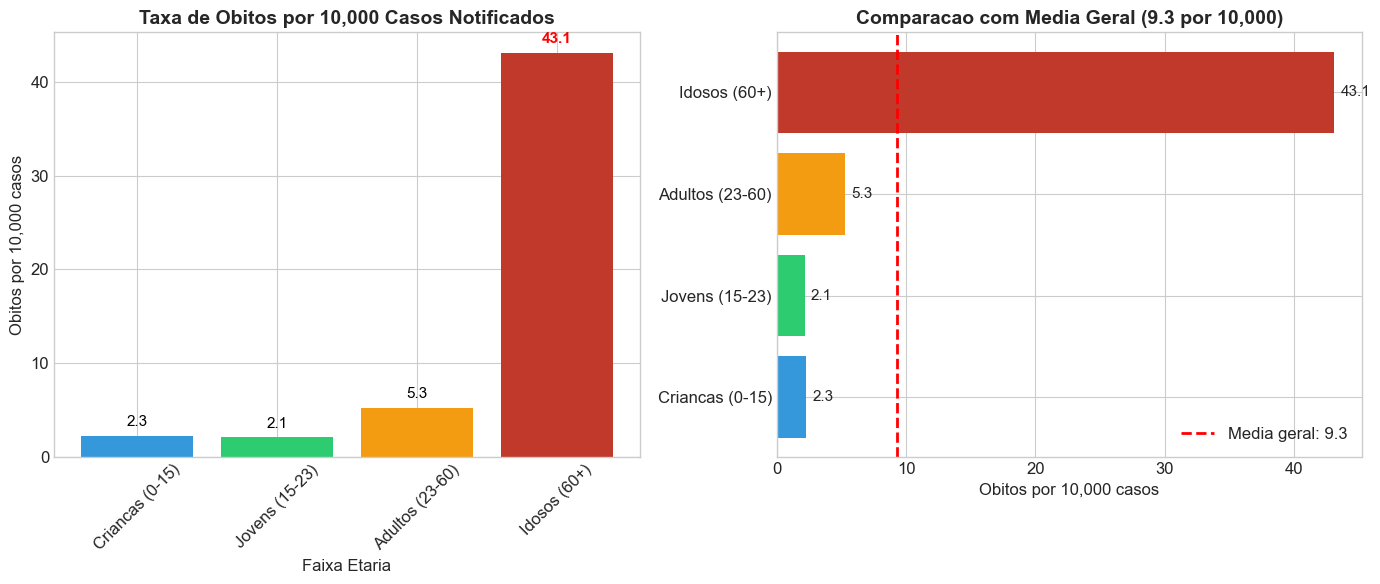

In [7]:
# Visualizacao: Taxa de Obitos Normalizada
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors_obitos = ['#3498db', '#2ecc71', '#f39c12', '#c0392b']

# Grafico de barras - Taxa por 10.000
taxa_col = f'Por {TAXA_BASE:,}'
bars = axes[0].bar(df_obitos_norm['Faixa Etaria'], df_obitos_norm[taxa_col], color=colors_obitos)
axes[0].set_title(f'Taxa de Obitos por {TAXA_BASE:,} Casos Notificados', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Faixa Etaria')
axes[0].set_ylabel(f'Obitos por {TAXA_BASE:,} casos')
axes[0].tick_params(axis='x', rotation=45)

# Destacar o valor de idosos
for i, (bar, val) in enumerate(zip(bars, df_obitos_norm[taxa_col])):
    color = 'red' if i == 3 else 'black'  # Destacar idosos
    weight = 'bold' if i == 3 else 'normal'
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val:.1f}', ha='center', fontsize=11, fontweight=weight, color=color)

# Grafico comparativo com linha de referencia (media geral)
bars2 = axes[1].barh(df_obitos_norm['Faixa Etaria'], df_obitos_norm[taxa_col], color=colors_obitos)
axes[1].axvline(x=taxa_geral_norm, color='red', linestyle='--', linewidth=2, label=f'Media geral: {taxa_geral_norm:.1f}')
axes[1].set_title(f'Comparacao com Media Geral ({taxa_geral_norm:.1f} por {TAXA_BASE:,})', fontsize=14, fontweight='bold')
axes[1].set_xlabel(f'Obitos por {TAXA_BASE:,} casos')
axes[1].legend()

for bar, val in zip(bars2, df_obitos_norm[taxa_col]):
    axes[1].text(val + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{val:.1f}', va='center', fontsize=11)

plt.tight_layout()
fig.savefig(f'{pasta_graficos}/02_taxa_obitos_normalizada.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Grafico salvo em: {pasta_graficos}/02_taxa_obitos_normalizada.png")
plt.show()

## 6. Taxa de Obitos Normalizada por Regiao

In [8]:
# Analise por regiao
df_regiao_valido = df_valido[df_valido['REGIAO'].notna()].copy()

print(f"{'='*80}")
print(f"TAXA DE OBITOS POR {TAXA_BASE:,} CASOS NOTIFICADOS - POR REGIAO")
print(f"{'='*80}")
print(f"\n{'Regiao':<15} {'Casos':>12} {'Obitos':>10} {'Taxa/%':>10} {'Por {0:,}'.format(TAXA_BASE):>12}")
print("-" * 65)

dados_regiao = []
regioes = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']

for regiao in regioes:
    df_reg = df_regiao_valido[df_regiao_valido['REGIAO'] == regiao]
    casos = len(df_reg)
    obitos = df_reg['OBITO'].sum()
    taxa_percentual = (obitos / casos * 100) if casos > 0 else 0
    taxa_normalizada = (obitos / casos * TAXA_BASE) if casos > 0 else 0
    
    print(f"{regiao:<15} {casos:>12,} {obitos:>10,} {taxa_percentual:>9.3f}% {taxa_normalizada:>11.1f}")
    dados_regiao.append({
        'Regiao': regiao,
        'Casos': casos,
        'Obitos': obitos,
        'Taxa (%)': taxa_percentual,
        f'Por {TAXA_BASE:,}': taxa_normalizada
    })

df_regiao_norm = pd.DataFrame(dados_regiao)

TAXA DE OBITOS POR 10,000 CASOS NOTIFICADOS - POR REGIAO

Regiao                 Casos     Obitos     Taxa/%   Por 10,000
-----------------------------------------------------------------
Norte                181,604        162     0.089%         8.9
Nordeste             795,264        567     0.071%         7.1
Centro-Oeste       1,365,565      1,466     0.107%        10.7
Sudeste            6,523,802      5,887     0.090%         9.0
Sul                2,132,135      2,129     0.100%        10.0


Grafico salvo em: GRAFICOS/NORMALIZADOS/03_taxa_obitos_regiao.png


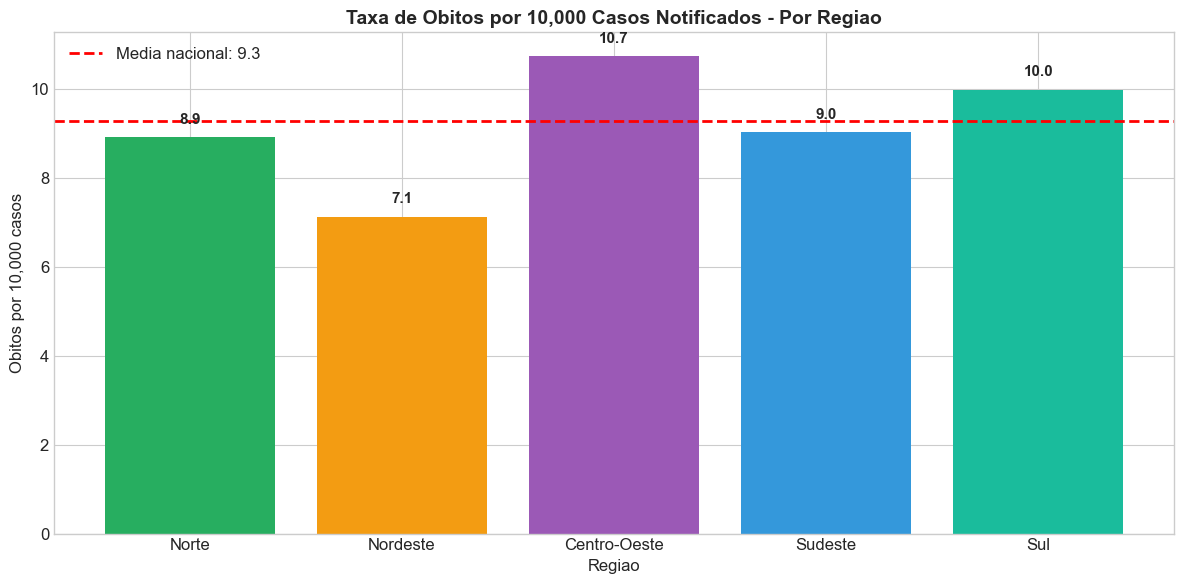

In [9]:
# Visualizacao: Taxa de Obitos por Regiao
fig, ax = plt.subplots(figsize=(12, 6))

colors_regiao = ['#27ae60', '#f39c12', '#9b59b6', '#3498db', '#1abc9c']
taxa_col = f'Por {TAXA_BASE:,}'

bars = ax.bar(df_regiao_norm['Regiao'], df_regiao_norm[taxa_col], color=colors_regiao)
ax.axhline(y=taxa_geral_norm, color='red', linestyle='--', linewidth=2, label=f'Media nacional: {taxa_geral_norm:.1f}')

ax.set_title(f'Taxa de Obitos por {TAXA_BASE:,} Casos Notificados - Por Regiao', fontsize=14, fontweight='bold')
ax.set_xlabel('Regiao')
ax.set_ylabel(f'Obitos por {TAXA_BASE:,} casos')
ax.legend()

for bar, val in zip(bars, df_regiao_norm[taxa_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{val:.1f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
fig.savefig(f'{pasta_graficos}/03_taxa_obitos_regiao.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Grafico salvo em: {pasta_graficos}/03_taxa_obitos_regiao.png")
plt.show()

## 7. Analise Cruzada: Regiao x Faixa Etaria (Taxas Normalizadas)

In [10]:
# Tabela cruzada: Taxa de obitos por regiao e faixa etaria
print(f"{'='*90}")
print(f"TAXA DE OBITOS POR {TAXA_BASE:,} CASOS - REGIAO x FAIXA ETARIA")
print(f"{'='*90}")

# Criar tabela de taxas
tabela_taxas = []
faixas_analise = ['Criancas (0-15)', 'Jovens (15-23)', 'Adultos (23-60)', 'Idosos (60+)']

for regiao in regioes:
    linha = {'Regiao': regiao}
    for faixa in faixas_analise:
        df_subset = df_regiao_valido[(df_regiao_valido['REGIAO'] == regiao) & 
                                      (df_regiao_valido['FAIXA_ETARIA'] == faixa)]
        casos = len(df_subset)
        obitos = df_subset['OBITO'].sum()
        taxa = (obitos / casos * TAXA_BASE) if casos > 0 else 0
        linha[faixa] = taxa
    tabela_taxas.append(linha)

df_taxas_cruzadas = pd.DataFrame(tabela_taxas)
df_taxas_cruzadas = df_taxas_cruzadas.set_index('Regiao')

print(f"\nTaxa de obitos por {TAXA_BASE:,} casos notificados:")
print(df_taxas_cruzadas.round(1).to_string())

TAXA DE OBITOS POR 10,000 CASOS - REGIAO x FAIXA ETARIA

Taxa de obitos por 10,000 casos notificados:
              Criancas (0-15)  Jovens (15-23)  Adultos (23-60)  Idosos (60+)
Regiao                                                                      
Norte                    4.40            6.00             7.90         35.30
Nordeste                 4.90            3.90             6.20         27.40
Centro-Oeste             3.90            2.40             7.00         52.60
Sudeste                  1.50            1.90             5.10         40.90
Sul                      1.50            1.40             4.30         48.30


Grafico salvo em: GRAFICOS/NORMALIZADOS/04_heatmap_taxas_cruzadas.png


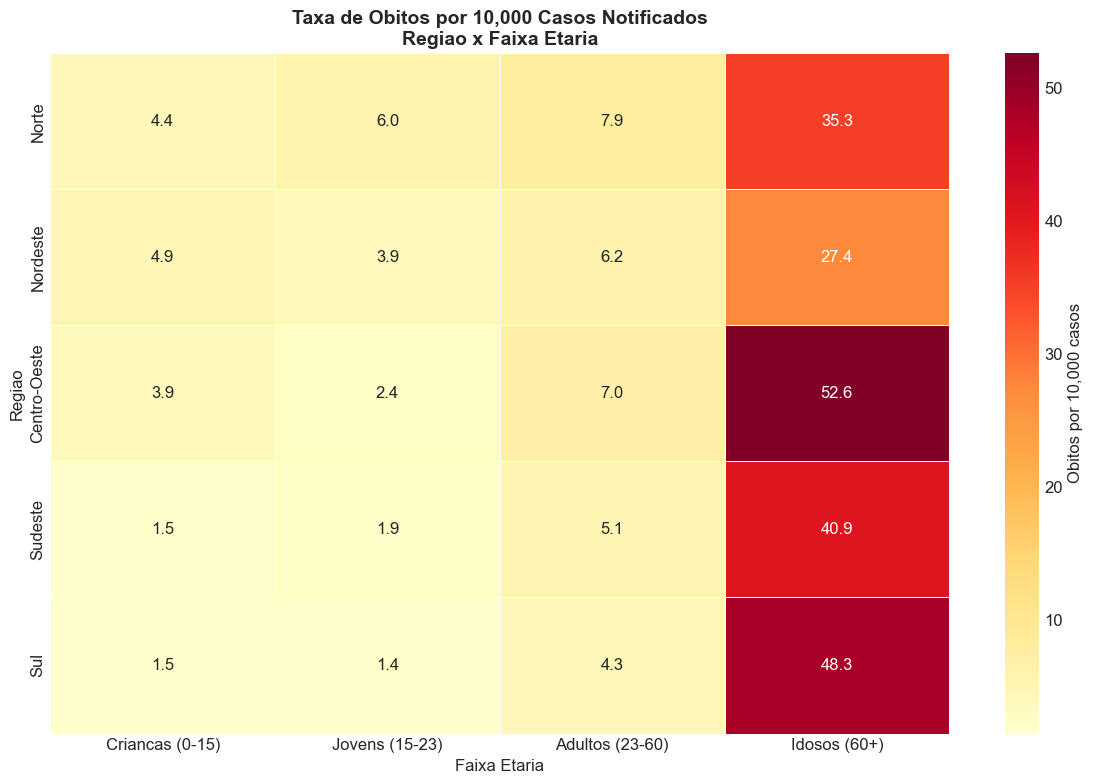

In [11]:
# Heatmap: Taxa de obitos por regiao e faixa etaria
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(df_taxas_cruzadas, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': f'Obitos por {TAXA_BASE:,} casos'},
            ax=ax)

ax.set_title(f'Taxa de Obitos por {TAXA_BASE:,} Casos Notificados\nRegiao x Faixa Etaria', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Faixa Etaria')
ax.set_ylabel('Regiao')

plt.tight_layout()
fig.savefig(f'{pasta_graficos}/04_heatmap_taxas_cruzadas.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Grafico salvo em: {pasta_graficos}/04_heatmap_taxas_cruzadas.png")
plt.show()

## 8. Frequencia de Sintomas Normalizada

In [12]:
# Lista de sintomas
colunas_sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 
                    'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N',
                    'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 
                    'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE']

traducao_sintomas = {
    'FEBRE': 'Febre', 'MIALGIA': 'Dor muscular', 'CEFALEIA': 'Dor de cabeca',
    'EXANTEMA': 'Manchas na pele', 'VOMITO': 'Vomito', 'NAUSEA': 'Nausea',
    'DOR_COSTAS': 'Dor nas costas', 'CONJUNTVIT': 'Conjuntivite', 'ARTRITE': 'Artrite',
    'ARTRALGIA': 'Dor nas articulacoes', 'PETEQUIA_N': 'Petequias', 'LEUCOPENIA': 'Leucopenia',
    'LACO': 'Prova do laco', 'DOR_RETRO': 'Dor retro-orbital', 'DIABETES': 'Diabetes',
    'HEMATOLOG': 'Doenca hematologica', 'HEPATOPAT': 'Hepatopatia', 'RENAL': 'Doenca renal',
    'HIPERTENSA': 'Hipertensao', 'ACIDO_PEPT': 'Doenca acido-peptica', 'AUTO_IMUNE': 'Doenca autoimune'
}

# Calcular frequencia de sintomas por faixa etaria (por 10.000 casos com resposta valida)
print(f"{'='*80}")
print(f"FREQUENCIA DE SINTOMAS POR {TAXA_BASE:,} CASOS COM RESPOSTA VALIDA")
print(f"{'='*80}")

sintomas_por_faixa = {}
for faixa in faixas_analise:
    df_faixa = df_valido[df_valido['FAIXA_ETARIA'] == faixa]
    sintomas_faixa = {}
    
    for col in colunas_sintomas:
        if col in df.columns:
            total_com_sintoma = (df_faixa[col] == 1).sum()
            total_validos = df_faixa[col].isin([1, 2]).sum()
            
            if total_validos > 0:
                taxa_normalizada = (total_com_sintoma / total_validos) * TAXA_BASE
                nome_sintoma = traducao_sintomas.get(col, col)
                sintomas_faixa[nome_sintoma] = taxa_normalizada
    
    sintomas_por_faixa[faixa] = sintomas_faixa

df_sintomas_norm = pd.DataFrame(sintomas_por_faixa).round(1)
print(f"\nTop 10 Sintomas por Faixa Etaria (por {TAXA_BASE:,} casos com resposta):")
df_sintomas_norm.head(10)

FREQUENCIA DE SINTOMAS POR 10,000 CASOS COM RESPOSTA VALIDA

Top 10 Sintomas por Faixa Etaria (por 10,000 casos com resposta):


,Criancas (0-15),Jovens (15-23),Adultos (23-60),Idosos (60+)
Febre,9178.30,8774.50,8470.00,7693.30
Dor muscular,6585.00,8229.40,8338.60,7912.50
Dor de cabeca,7034.10,8511.50,8289.50,7270.90
Manchas na pele,1268.80,953.20,1044.20,804.90
Vomito,3288.60,2862.20,2465.10,2419.70
Nausea,3647.40,4505.00,4408.60,4228.40
Dor nas costas,1689.40,3142.10,3392.90,3097.70
Conjuntivite,324.20,379.80,393.60,330.50
Artrite,552.60,919.00,1105.20,1057.00
Dor nas articulacoes,925.30,1693.50,2062.30,1832.30


Grafico salvo em: GRAFICOS/NORMALIZADOS/05_heatmap_sintomas_normalizado.png


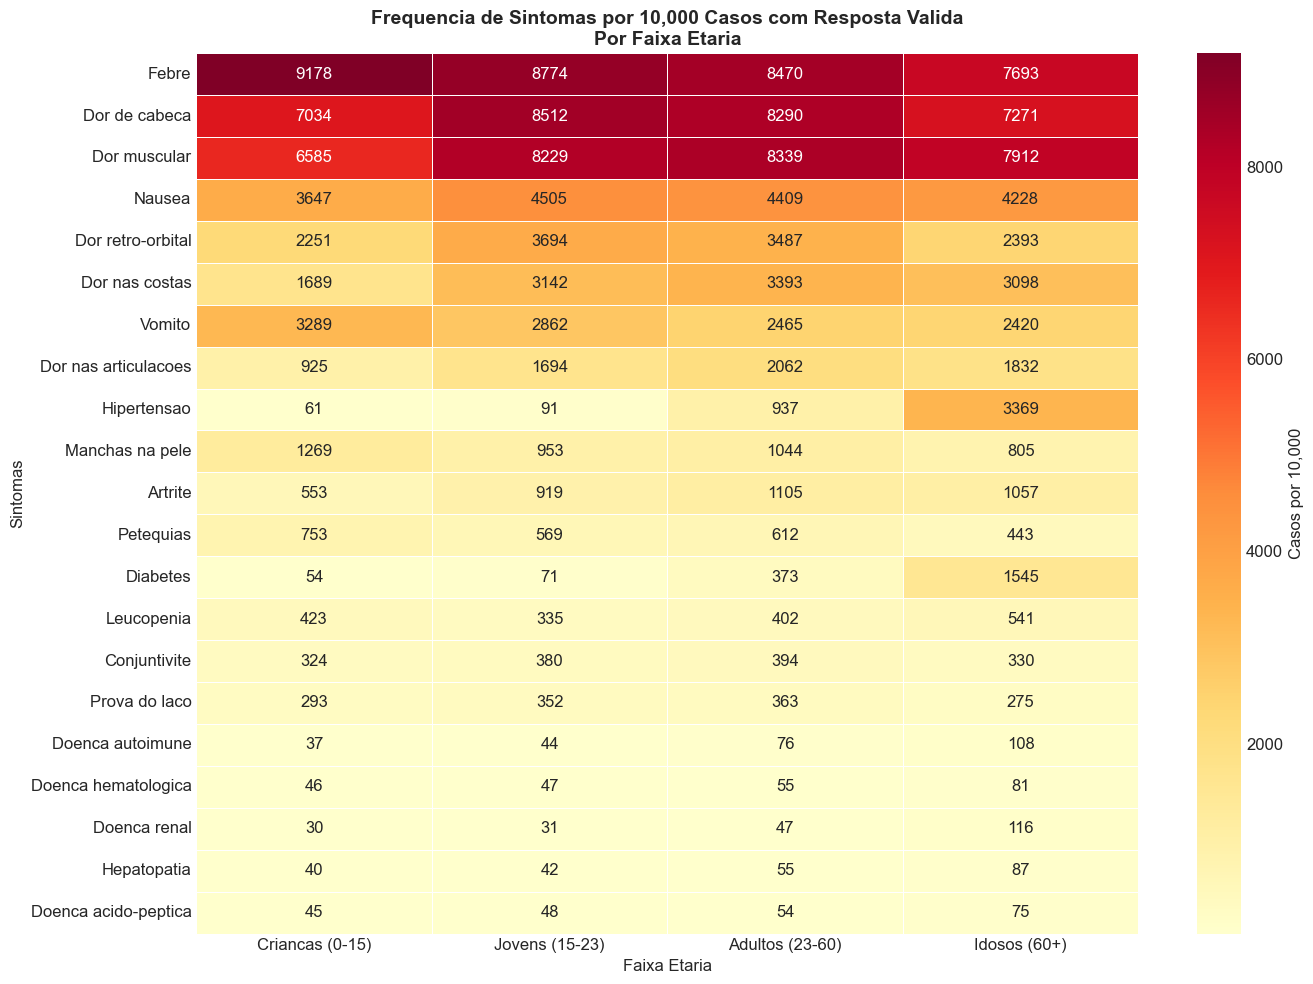

In [13]:
# Visualizacao: Heatmap de Sintomas Normalizado
fig, ax = plt.subplots(figsize=(14, 10))

# Ordenar por frequencia media
df_sintomas_plot = df_sintomas_norm.copy()
df_sintomas_plot['Media'] = df_sintomas_plot.mean(axis=1)
df_sintomas_plot = df_sintomas_plot.sort_values('Media', ascending=False).drop('Media', axis=1)

sns.heatmap(df_sintomas_plot, annot=True, fmt='.0f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': f'Casos por {TAXA_BASE:,}'},
            ax=ax)

ax.set_title(f'Frequencia de Sintomas por {TAXA_BASE:,} Casos com Resposta Valida\nPor Faixa Etaria', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Faixa Etaria')
ax.set_ylabel('Sintomas')

plt.tight_layout()
fig.savefig(f'{pasta_graficos}/05_heatmap_sintomas_normalizado.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Grafico salvo em: {pasta_graficos}/05_heatmap_sintomas_normalizado.png")
plt.show()

## 9. Dashboard Resumo - Taxas Normalizadas

Dashboard salvo em: GRAFICOS/NORMALIZADOS/06_dashboard_normalizado.png


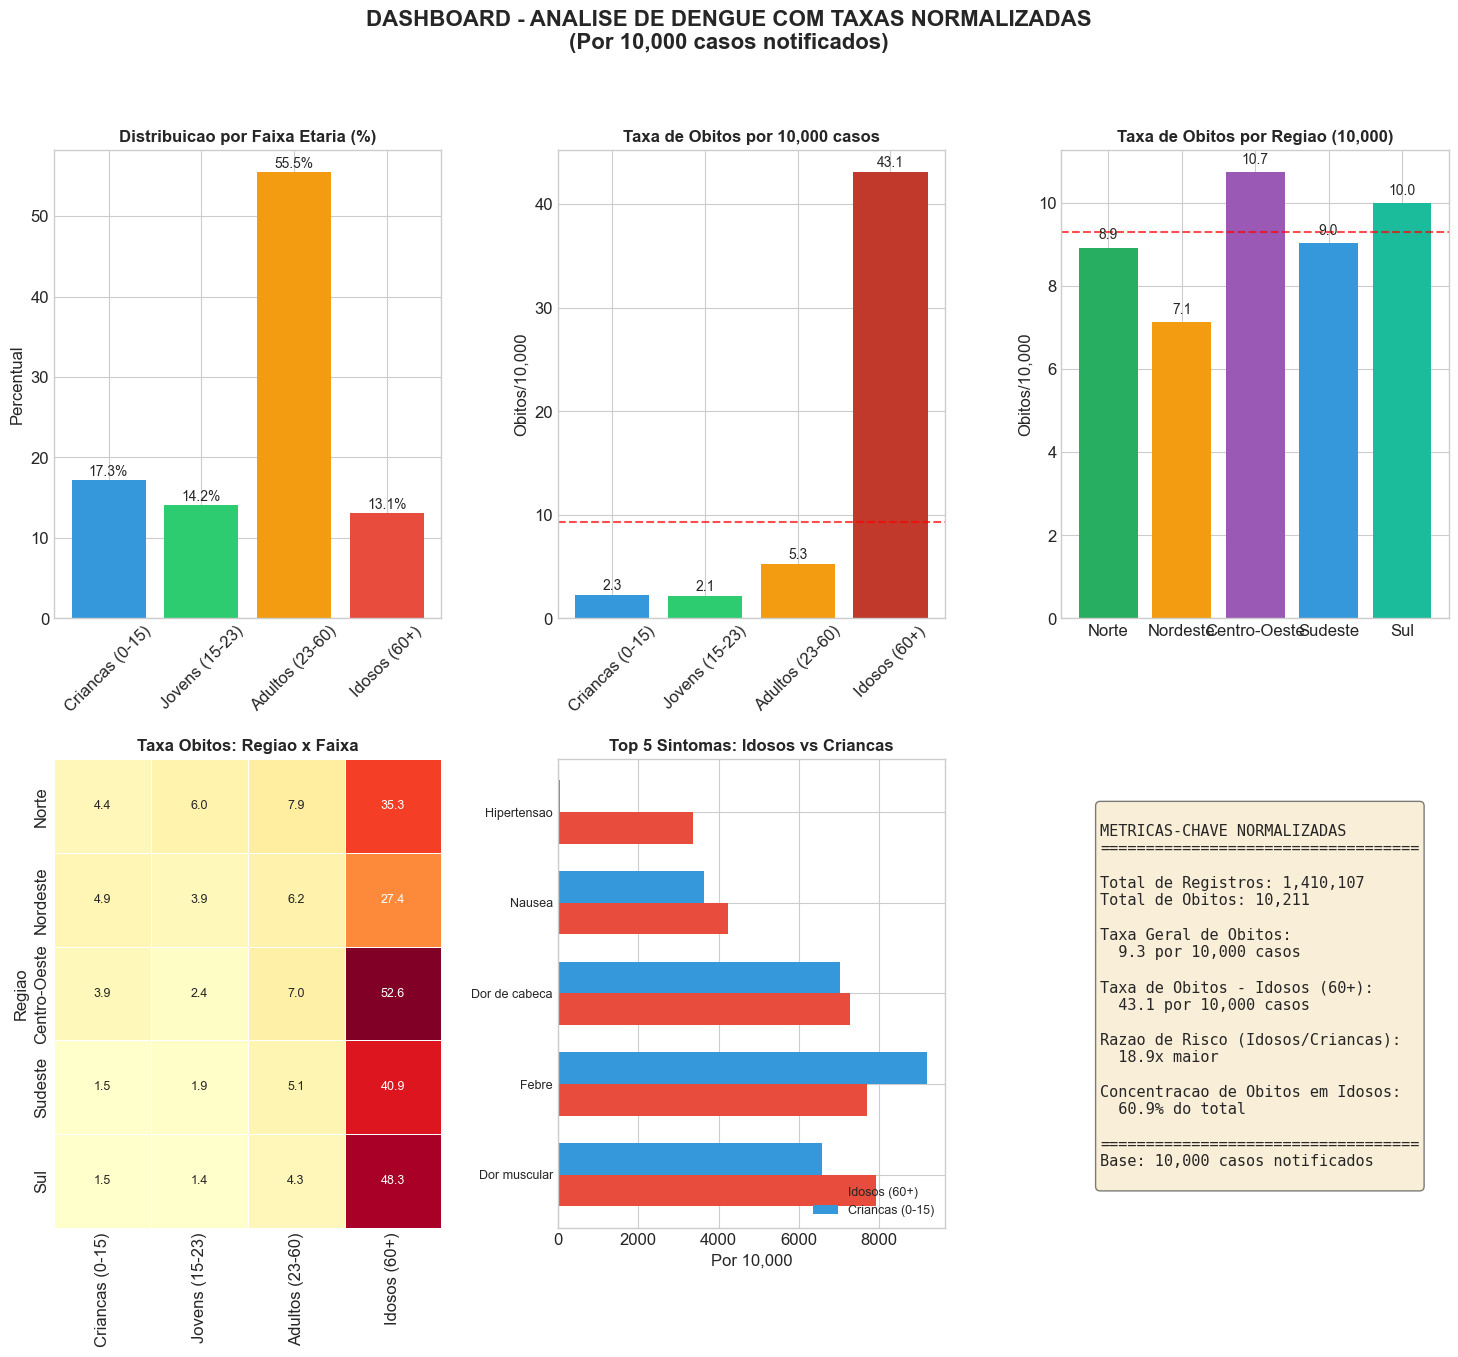

In [14]:
# Dashboard com todas as metricas normalizadas
fig = plt.figure(figsize=(18, 14))

# Layout: 2x3
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Distribuicao por Faixa Etaria
ax1 = fig.add_subplot(gs[0, 0])
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = ax1.bar(df_dist_normalizada['Faixa Etaria'], df_dist_normalizada['Percentual'], color=colors)
ax1.set_title('Distribuicao por Faixa Etaria (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentual')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, df_dist_normalizada['Percentual']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%', ha='center', fontsize=10)

# 2. Taxa de Obitos por Faixa Etaria
ax2 = fig.add_subplot(gs[0, 1])
taxa_col = f'Por {TAXA_BASE:,}'
colors_obitos = ['#3498db', '#2ecc71', '#f39c12', '#c0392b']
bars = ax2.bar(df_obitos_norm['Faixa Etaria'], df_obitos_norm[taxa_col], color=colors_obitos)
ax2.axhline(y=taxa_geral_norm, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_title(f'Taxa de Obitos por {TAXA_BASE:,} casos', fontsize=12, fontweight='bold')
ax2.set_ylabel(f'Obitos/{TAXA_BASE:,}')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars, df_obitos_norm[taxa_col]):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=10)

# 3. Taxa de Obitos por Regiao
ax3 = fig.add_subplot(gs[0, 2])
colors_regiao = ['#27ae60', '#f39c12', '#9b59b6', '#3498db', '#1abc9c']
bars = ax3.bar(df_regiao_norm['Regiao'], df_regiao_norm[taxa_col], color=colors_regiao)
ax3.axhline(y=taxa_geral_norm, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_title(f'Taxa de Obitos por Regiao ({TAXA_BASE:,})', fontsize=12, fontweight='bold')
ax3.set_ylabel(f'Obitos/{TAXA_BASE:,}')
for bar, val in zip(bars, df_regiao_norm[taxa_col]):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}', ha='center', fontsize=10)

# 4. Heatmap Regiao x Faixa (menor)
ax4 = fig.add_subplot(gs[1, 0])
sns.heatmap(df_taxas_cruzadas, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar=False, ax=ax4, annot_kws={'size': 9})
ax4.set_title(f'Taxa Obitos: Regiao x Faixa', fontsize=12, fontweight='bold')

# 5. Top 5 Sintomas (Idosos vs Criancas)
ax5 = fig.add_subplot(gs[1, 1])
top_sintomas_idosos = df_sintomas_norm['Idosos (60+)'].sort_values(ascending=False).head(5)
top_sintomas_criancas = df_sintomas_norm['Criancas (0-15)'].sort_values(ascending=False).head(5)

x = np.arange(5)
width = 0.35
ax5.barh(x - width/2, top_sintomas_idosos.values, width, label='Idosos (60+)', color='#e74c3c')
ax5.barh(x + width/2, [df_sintomas_norm.loc[s, 'Criancas (0-15)'] for s in top_sintomas_idosos.index], 
         width, label='Criancas (0-15)', color='#3498db')
ax5.set_yticks(x)
ax5.set_yticklabels(top_sintomas_idosos.index, fontsize=9)
ax5.set_xlabel(f'Por {TAXA_BASE:,}')
ax5.set_title('Top 5 Sintomas: Idosos vs Criancas', fontsize=12, fontweight='bold')
ax5.legend(loc='lower right', fontsize=9)

# 6. Metricas Resumo
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')

# Calcular metricas
taxa_idosos = df_obitos_norm[df_obitos_norm['Faixa Etaria'] == 'Idosos (60+)'][taxa_col].values[0]
taxa_criancas = df_obitos_norm[df_obitos_norm['Faixa Etaria'] == 'Criancas (0-15)'][taxa_col].values[0]
razao_idosos_criancas = taxa_idosos / taxa_criancas if taxa_criancas > 0 else 0

pct_obitos_idosos = (df_obitos_norm[df_obitos_norm['Faixa Etaria'] == 'Idosos (60+)']['Obitos'].values[0] / 
                    df_obitos_norm['Obitos'].sum()) * 100

resumo_texto = f"""
METRICAS-CHAVE NORMALIZADAS
{'='*35}

Total de Registros: {total_validos:,}
Total de Obitos: {total_obitos:,}

Taxa Geral de Obitos:
  {taxa_geral_norm:.1f} por {TAXA_BASE:,} casos

Taxa de Obitos - Idosos (60+):
  {taxa_idosos:.1f} por {TAXA_BASE:,} casos

Razao de Risco (Idosos/Criancas):
  {razao_idosos_criancas:.1f}x maior

Concentracao de Obitos em Idosos:
  {pct_obitos_idosos:.1f}% do total

{'='*35}
Base: {TAXA_BASE:,} casos notificados
"""

ax6.text(0.1, 0.9, resumo_texto, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'DASHBOARD - ANALISE DE DENGUE COM TAXAS NORMALIZADAS\n(Por {TAXA_BASE:,} casos notificados)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig(f'{pasta_graficos}/06_dashboard_normalizado.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Dashboard salvo em: {pasta_graficos}/06_dashboard_normalizado.png")
plt.show()

## 10. Exportar Tabelas Resumo

In [15]:
# Resumo final em formato tabular
print(f"\n{'='*90}")
print("RESUMO EXECUTIVO - ANALISE NORMALIZADA DE DENGUE (2022-2025)")
print(f"{'='*90}")

print(f"\n1. DISTRIBUICAO POR FAIXA ETARIA")
print("-" * 70)
print(df_dist_normalizada.to_string(index=False))

print(f"\n\n2. TAXA DE OBITOS POR FAIXA ETARIA (por {TAXA_BASE:,} casos)")
print("-" * 70)
print(df_obitos_norm.to_string(index=False))

print(f"\n\n3. TAXA DE OBITOS POR REGIAO (por {TAXA_BASE:,} casos)")
print("-" * 70)
print(df_regiao_norm.to_string(index=False))

print(f"\n\n4. MATRIZ REGIAO x FAIXA ETARIA (obitos por {TAXA_BASE:,} casos)")
print("-" * 70)
print(df_taxas_cruzadas.round(1).to_string())

print(f"\n\n5. INSIGHTS PRINCIPAIS")
print("-" * 70)
print(f"  - Idosos (60+) tem taxa de obitos {razao_idosos_criancas:.1f}x maior que criancas")
print(f"  - Idosos concentram {pct_obitos_idosos:.1f}% dos obitos totais")
print(f"  - Taxa geral: {taxa_geral_norm:.1f} obitos por {TAXA_BASE:,} casos notificados")

print(f"\n\n{'='*90}")
print("Analise normalizada concluida!")
print(f"Graficos salvos em: {pasta_graficos}/")


RESUMO EXECUTIVO - ANALISE NORMALIZADA DE DENGUE (2022-2025)

1. DISTRIBUICAO POR FAIXA ETARIA
----------------------------------------------------------------------
   Faixa Etaria   Casos  Percentual  Por 10,000
Criancas (0-15) 1898084       17.26     1725.79
 Jovens (15-23) 1556891       14.16     1415.57
Adultos (23-60) 6100176       55.46     5546.44
   Idosos (60+) 1443219       13.12     1312.21


2. TAXA DE OBITOS POR FAIXA ETARIA (por 10,000 casos)
----------------------------------------------------------------------
   Faixa Etaria   Casos  Obitos  Taxa (%)  Por 10,000
Criancas (0-15) 1898084     432      0.02        2.28
 Jovens (15-23) 1556891     334      0.02        2.15
Adultos (23-60) 6100176    3224      0.05        5.29
   Idosos (60+) 1443219    6221      0.43       43.11


3. TAXA DE OBITOS POR REGIAO (por 10,000 casos)
----------------------------------------------------------------------
      Regiao   Casos  Obitos  Taxa (%)  Por 10,000
       Norte  181604    